<a href="https://colab.research.google.com/github/SamuelMiller413/Deep-Learning-Course/blob/main/DL11_CNNs_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install -Uqq fastai
!apt-get install tree

In [ ]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from fastai.vision.all import *
from fastai import *
from torchvision import transforms
import pandas as pd

In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
print('First 2 levels of the data directory... \n')
!tree -L 2 {str(path)}
# print('\nLooking at the first 10 files in the training/0 directory...\n')
!ls {str(path/'training/0')} | head -n 10

First 2 levels of the data directory... 

/root/.fastai/data/mnist_png
├── testing
│   ├── 0
│   ├── 1
│   ├── 2
│   ├── 3
│   ├── 4
│   ├── 5
│   ├── 6
│   ├── 7
│   ├── 8
│   └── 9
└── training
    ├── 0
    ├── 1
    ├── 2
    ├── 3
    ├── 4
    ├── 5
    ├── 6
    ├── 7
    ├── 8
    └── 9

22 directories, 0 files
10005.png
1000.png
10010.png
10022.png
10025.png
10026.png
10045.png
10069.png
10071.png
10080.png


In [ ]:
dls = ImageDataLoaders.from_folder(path, 'training', 'testing')

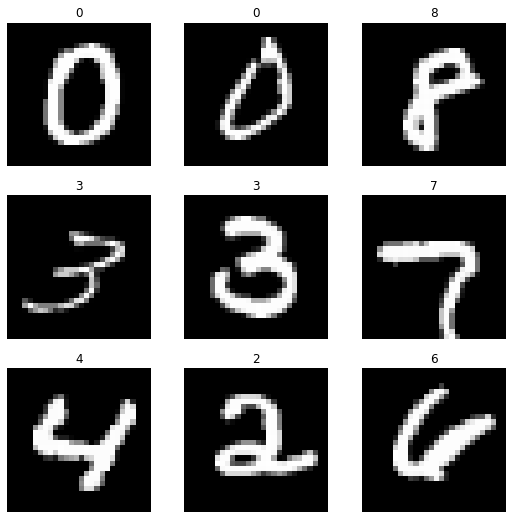

In [ ]:
dls.show_batch()

In [ ]:
x_b, y_b = dls.one_batch()

x_b.max(), x_b.min(), x_b.shape, y_b

(TensorImage(1., device='cuda:0'),
 TensorImage(0., device='cuda:0'),
 torch.Size([64, 3, 28, 28]),
 TensorCategory([9, 0, 9, 5, 8, 6, 3, 4, 4, 7, 9, 0, 3, 6, 5, 8, 9, 7, 4, 3, 0,
                 7, 9, 0, 7, 4, 1, 3, 0, 5, 1, 7, 1, 7, 5, 7, 7, 2, 5, 6, 1, 4,
                 2, 2, 6, 1, 9, 1, 2, 0, 0, 0, 0, 6, 3, 2, 1, 4, 0, 2, 3, 3, 6,
                 4], device='cuda:0'))

In [ ]:
def conv_block(in_channels, out_channels, kernel_size=3, padding=1, stride=1, dropout=0.2, *args, **kwargs):
    """
    Returns a sequential module of a conv block that we want to repeat.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, **kwargs),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Dropout2d(dropout)
    )

In [ ]:
# Build our model
model = nn.Sequential(
    conv_block(3, 32), # 3x28x28 --> 32x28x28
    conv_block(32, 64), # 32x28x28 --> 64x28x28
    conv_block(64, 64, stride=2), # 64x28x28 --> 64x14x14
    conv_block(64, 128), # 64x14x14 --> 128x14x14
    conv_block(128, 128, stride=2), # 128x14x14 --> 128x7x7
    nn.AdaptiveMaxPool2d(1), # 128x7x7 --> 128
    nn.Flatten(), # 1x1x128 --> 128
    nn.Linear(128, 10) # 128 features --> 10 outputs
)

# Display our model
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
cbs = [
    EarlyStoppingCallback()
]

mets = [
    metrics.accuracy,
    metrics.error_rate
]

loss = CrossEntropyLossFlat()

In [ ]:
learn = Learner(dls, model, loss, metrics=mets, cbs=cbs)

In [ ]:
LR = 1e-3
learn.fit_one_cycle(2, LR)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.128293,0.046193,0.985400,0.014600,01:41
1,0.058892,0.026236,0.991900,0.008100,01:34


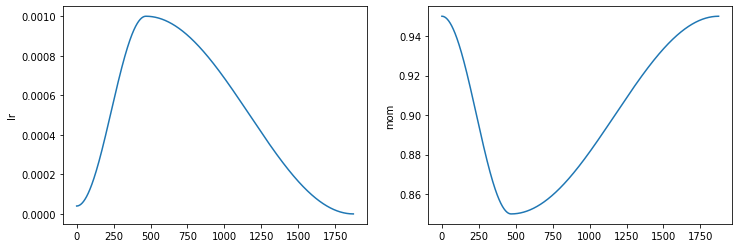

In [ ]:
learn.recorder.plot_sched()

In [ ]:
def visualize_filters(layer, batch, batch_idx):
    with hook_output(model[layer][0]) as hook:
        # Pass one batch through the model, outputs will be stored in hook.stored
        with torch.no_grad():
            _ = learn.model(batch)
            # Store the outputs
            outputs = hook.stored

    # Pick an index in the batch
    n_filters = outputs.shape[1]
    output_size = outputs.shape[2]
    # Pick 9 random filters to visualize
    sampled_filters = np.random.choice(range(n_filters), 9)

    # Show the outputs for our 9 randomly sampled filters
    fig = plt.figure(figsize=(10, 10))
    for i, fidx in enumerate(sampled_filters):
        ax = fig.add_subplot(3, 3, 1+i)
        if i == 0: # Plot the original image in the upper left
            show_image(batch[batch_idx], title='Original', ax=ax)
            # plt.close()
        else: # Plot activation maps of the randomly sampled filters
            ax.matshow(
                outputs[batch_idx, fidx].squeeze().cpu().numpy(), 
                cmap='Greys_r'
            )
        # Get rid of ticks & labels
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticklabels([])
        ax.set_yticks([])
    fig.tight_layout()
    plt.close()
    return fig

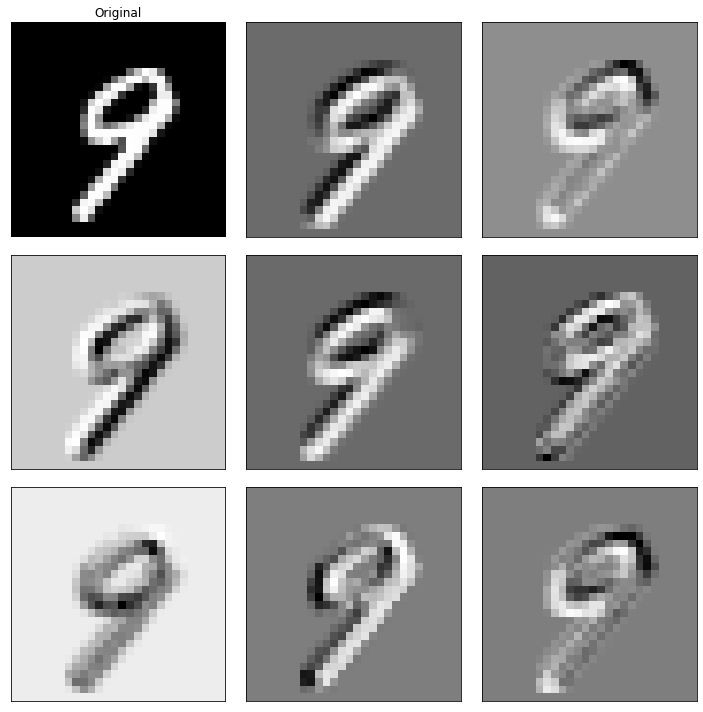

In [ ]:
visualize_filters(0, x_b, 2)

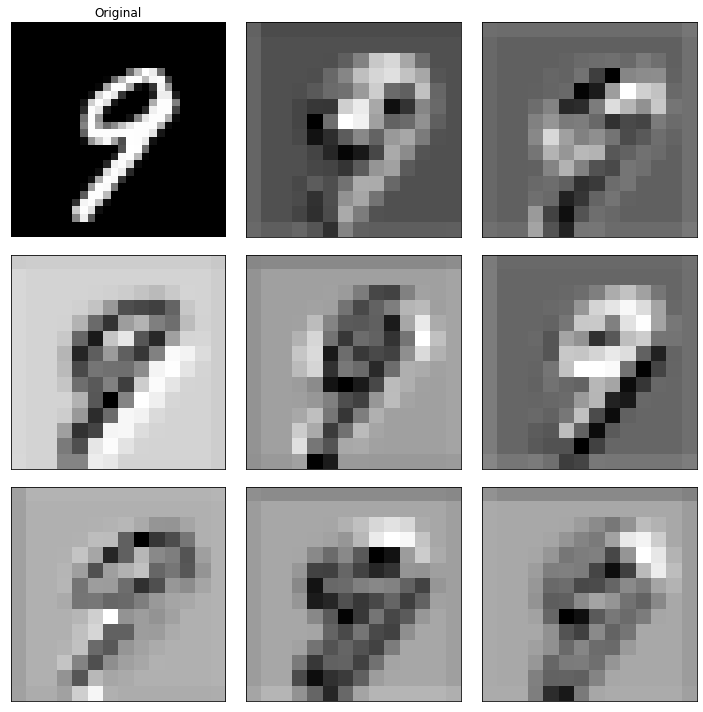

In [ ]:
visualize_filters(2, x_b, 2)

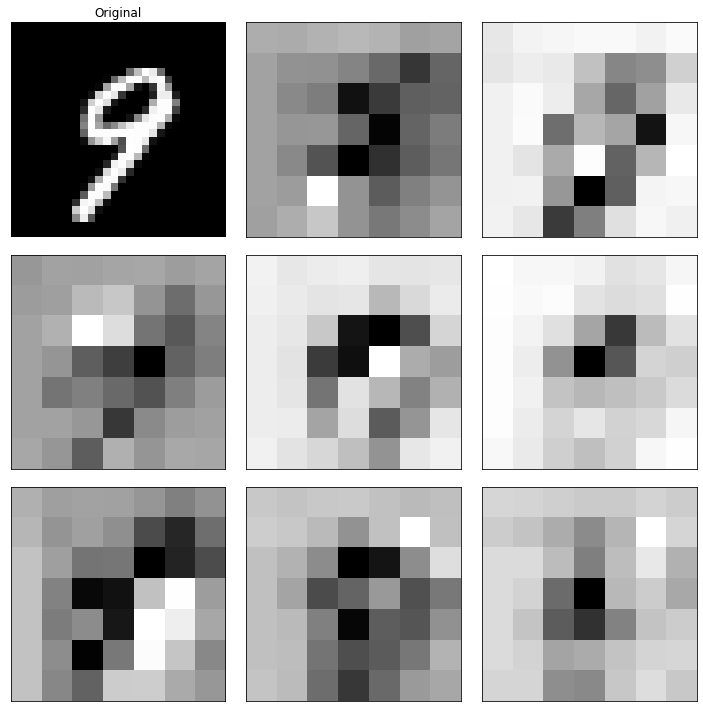

In [ ]:
visualize_filters(4, x_b, 2)